In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [2]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM", "ADBE", "SNPS", "INTC", "AAPL", "MSFT", "GOOGL", "META", "AMZN",
    "QCOM", "TXN", "AMAT", "NOW", "RNG", "HPE", "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", 
    "ZS", "PANW", "SNOW", "DDOG", "CRWD", "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI", 
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC", "NKE", "LULU", "TJX", "COST", "HD", "LOW",
    "TGT", "WMT", "BBY", "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT", "JNJ", "PFE", 
    "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", 
    "BDX", "DHR", "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB", "DIS", "EA", "MO", "CL", "EL", "KHC", 
    "UL", "NSRGY", "COTY", "MCD", "YUM", "SBUX", "DASH", "WBA", "XOM", "CVX", "SLB", "OXY", "PXD", "COP", 
    "BKR", "VLO", "PSX", "APD", "LIN", "DOW", "DD", "SHW", "PPG", "NOC", "LMT", "GD", "RTX", "BA", "GE", 
    "CAT", "MMM", "HON", "ITW", "EMR", "DHR", "UNH", "CI", "HUM", "ANTM", "CNC"
]

data = pd.DataFrame()


In [3]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [4]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5', 'RSI15', 'BB_upper', 'ATR', 'MACD', 'OBV', 'CMF']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()
       standard_scaler_close = StandardScaler()

       price_columns.pop()

       uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [5]:
def calculate_tech_ind(curr, data):
    # Trend Indicators
    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Short-term Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Short-term Exponential Moving Average
    
    # Momentum Indicators
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
    
    # Volatility Indicators
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=20, std=2).iloc[:, [0, 2]].T.values  # Bollinger Bands
    data['ATR'] = ta.atr(curr['High'], curr['Low'], curr['Close'], length=14)  # Average True Range
    
    # Volume Indicators
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])  # On-Balance Volume
    data['CMF'] = ta.ad(curr['High'], curr['Low'], curr['Close'], curr['Volume']) / ta.sma(curr['Volume'], length=20)  # Chaikin Money Flow
    
    # Additional: Ichimoku Cloud and Percentage Price Oscillator (PPO)
    #ichimoku_df, _ = ta.ichimoku(curr['High'], curr['Low'], curr['Close'])
    #data['Ichimoku_base'] = ichimoku_df['ISB_26']
    # ppo_values = ta.ppo(curr['Close'])  # Percentage Price Oscillator
    # data['PPO'] = ppo_values['PPO']

    # Clean and Scale Data
    uncleaned_data = pd.concat([curr, data], axis=0)
    uncleaned_data = uncleaned_data.iloc[14:, :]  # Discard initial rows to avoid NaNs
    uncleaned_data.fillna(method='ffill', inplace=True)
    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    return scaled_data


In [6]:
for i in companies:
    try:

        curr = yf.download(i, period="max")

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

Input X contains infinity or a value too large for dtype('float64'). UL


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

'NoneType' object has no attribute 'iloc' PXD


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

'NoneType' object has no attribute 'iloc' ANTM


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line


In [7]:
scaled_data = data
scaled_data = scaled_data.drop_duplicates()

In [8]:
def print_column_ranges(data):
    for col in data.columns:
        col_min = data[col].min()
        col_max = data[col].max()
        col_range = col_max - col_min
        print(f"{col}: Min = {col_min}, Max = {col_max}, Range = {col_range}")

print_column_ranges(data)

Adj Close: Min = 0.001566744758747518, Max = 4776.4599609375, Range = 4776.458394192741
Close: Min = 0.00520800007507205, Max = 4776.4599609375, Range = 4776.454752937425
High: Min = -49.38390262290432, Max = 20.807345464495793, Range = 70.19124808740011
Low: Min = -53.04323557145557, Max = 7.595754268905466, Range = 60.638989840361035
Open: Min = -36.654014217314554, Max = 39.09579471379557, Range = 75.74980893111012
Volume: Min = -28.123476917690933, Max = 53.19872322087064, Range = 81.32220013856157
SMA15: Min = -4.337207361705133, Max = 9.723540886345702, Range = 14.060748248050835
EMA5: Min = -3.999197168240828, Max = 9.72858117293079, Range = 13.727778341171618
RSI15: Min = -5.323835984836832, Max = 5.115660905388815, Range = 10.439496890225648
MACD: Min = -29.86237799748593, Max = 17.9927890459182, Range = 47.85516704340413
MACD_signal: Min = -72.15889841588559, Max = 49.63156889633965, Range = 121.79046731222525
BB_upper: Min = -4.510970267576461, Max = 10.157339050736235, Rang

In [9]:
scaled_data.shape

(2412454, 16)

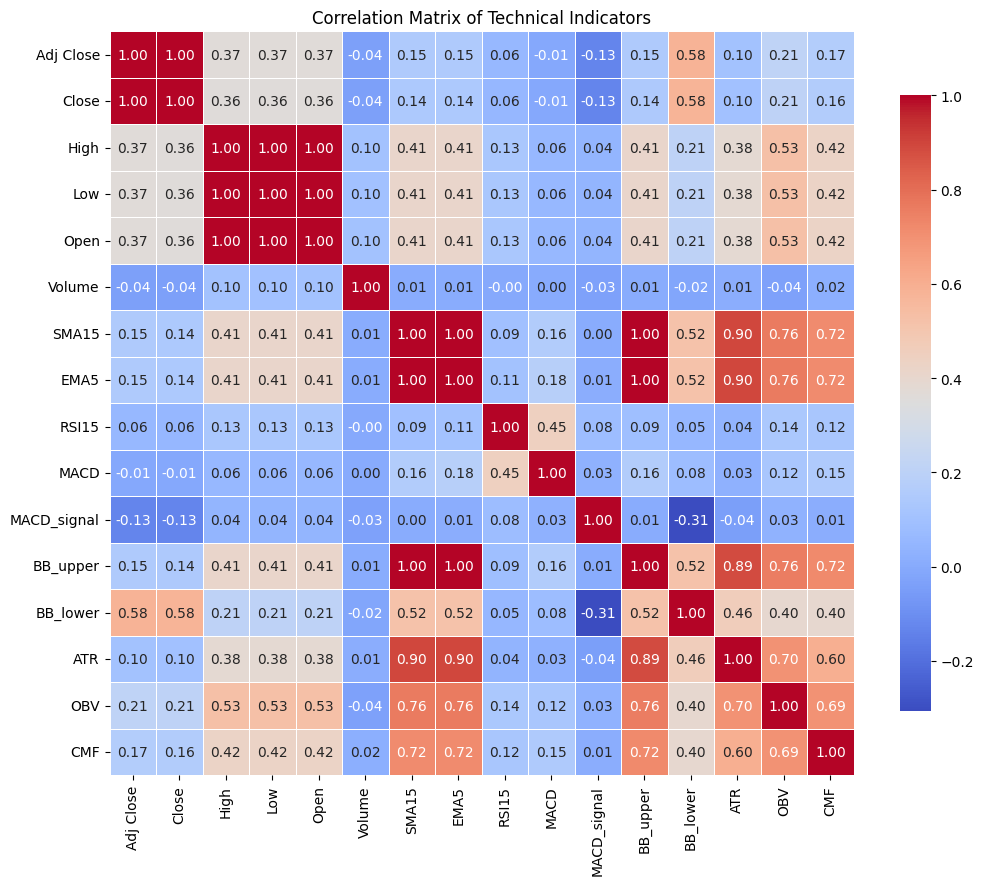

In [10]:
correlation_matrix = scaled_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seabornE
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [11]:
target_classification = (scaled_data['Close'].shift(-1) > scaled_data['Close']).astype(int)

In [12]:
input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [13]:
print(input.shape)
print(target_classification.shape)

(2412454, 8)
(2412454,)


In [14]:
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(input, target_classification, test_size=0.2, random_state=42)

In [15]:
print(X_train_cal.shape, y_train_cal.shape)

(1929963, 8) (1929963,)


In [16]:
X_train_cal = X_train_cal[:len(X_train_cal) // 2]
y_train_cal = y_train_cal[:len(y_train_cal) // 2]
X_test_cal = X_test_cal[:len(X_test_cal) // 2]
y_test_cal = y_test_cal[:len(y_test_cal) // 2]

print(X_train_cal.shape, y_train_cal.shape)

(964981, 8) (964981,)


C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\1079823000.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_cal = y_train_cal[:len(y_train_cal) // 2]
C:\Users\Nishc\AppData\Local\Temp\ipykernel_33072\1079823000.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test_cal = y_test_cal[:len(y_test_cal) // 2]


In [17]:
X_train_cal = X_train_cal.values
X_train_cal = X_train_cal.reshape((X_train_cal.shape[0], 1, X_train_cal.shape[1]))
X_train_cal.shape

(964981, 1, 8)

In [18]:
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(None, 8), return_sequences=True))

model.add(LSTM(32, activation='relu', return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train_cal, y_train_cal, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/5


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


24125/24125 - 322s - loss: 0.1267 - val_loss: 0.1234 - 322s/epoch - 13ms/step
Epoch 2/5
24125/24125 - 612s - loss: 0.1241 - val_loss: 0.1232 - 612s/epoch - 25ms/step
Epoch 3/5
24125/24125 - 473s - loss: 0.1236 - val_loss: 0.1222 - 473s/epoch - 20ms/step
Epoch 4/5
24125/24125 - 493s - loss: 0.1234 - val_loss: 0.1220 - 493s/epoch - 20ms/step
Epoch 5/5
24125/24125 - 672s - loss: 0.1232 - val_loss: 0.1222 - 672s/epoch - 28ms/step


In [20]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Updated model architecture
# model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train_cal.shape[1],)),
#     layers.Dropout(0.3),  # Dropout for regularization
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
# ])

# # Compile with binary crossentropy loss
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train model
# model.fit(X_train_cal, y_train_cal, epochs=100, batch_size=32, validation_split=0.2)

# # Predictions and evaluation
# y_pred_prob = model.predict(X_test_cal)
# y_pred = (y_pred_prob > 0.5).astype("int32")  # Threshold for classification

# # Calculate accuracy
# accuracy = accuracy_score(y_test_cal, y_pred)
# print(f'Accuracy: {accuracy}')

# # Optional: View results and confusion matrix
# results = pd.DataFrame({
#     'Actual': y_test_cal,
#     'Predicted': y_pred.flatten()
# })
# print(results.head())

# conf_matrix = confusion_matrix(y_test_cal, y_pred)
# print("Confusion Matrix:\n", conf_matrix)


In [21]:
X_test_cal = X_test_cal.values
X_test_cal = X_test_cal.reshape((X_test_cal.shape[0], 1, X_test_cal.shape[1]))
X_test_cal.shape

(241245, 1, 8)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, confusion_matrix

In [23]:
y_pred = model.predict(X_test_cal)

mse = mean_squared_error(y_test_cal, y_pred)
r2 = r2_score(y_test_cal, y_pred)

# Binary classification for increase/decrease
y_true_class = (y_test_cal.diff().fillna(0) > 0).astype(int)
y_pred_class = (y_pred.diff().fillna(0) > 0).astype(int)

# Classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

7539/7539 [==============================] - 80s 10ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [ ]:
conf_matrix = confusion_matrix(y_true_class, y_pred_class)
print(conf_matrix)